# Classification RBD vs Controls

In [1]:
import numpy as np 
import pandas as pd
import scipy.stats as sp
import math
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import matplotlib
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import Lasso, LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from collections import Counter

import seaborn as sns


from tqdm.notebook import tqdm
from joblib import Parallel, delayed


import warnings
warnings.filterwarnings('ignore')


In [2]:
def my_classification(X_train, X_test, y_train, y_test, class_number = 2, features = 0, alpha = 0, n_features=1, n_split = 5, n_trials = 100, n_score = 1, param_search=True):
    
    warnings.filterwarnings('ignore')
    
    test_scores = np.zeros((n_trials, n_scores))
    train_scores = np.zeros((n_trials, n_scores))
    best_param, best_f = list(), list()
    
    for i_N in range(n_trials):
   
        # STEP 1 - Search/Set best hyperparameters 
        if param_search == True: 
            pipe, param_grid = set_pipeline(alpha, param_search, n_features)
            grid_search = GridSearchCV(estimator = pipe, param_grid=param_grid, 
                                       scoring='f1', cv=n_split, n_jobs=10, verbose=0)
            grid_search.fit(X_train,y_train) 
            
            # Extract best features and best parameters   
            alpha_best = grid_search.best_params_['lasso__alpha']
            best_param.append(alpha_best)
            best_features = extract_features(grid_search.best_estimator_.named_steps["lasso"].coef_, features)
            best_f.append(best_features)     

            pipe, _ = set_pipeline(alpha = alpha_best, param_search=False)
        else:
            pipe, _ = set_pipeline(alpha = alpha, param_search = param_search)

        # STEP 2 - Learn model with best params
        pipe.fit(X_train, y_train)
        
        y_train_pred = pipe.predict(X_train)
        y_train_pred = np.int64(np.round(y_train_pred)) 
        
        train_scores[i_N,...] = compute_scores(y_train, y_train_pred)
    
        # STEP 3 - Estimate the model for the test set
        y_pred = pipe.predict(X_test)
        y_pred = np.int64(np.round(y_pred)) 

        # STEP 4 - Compute performance metrics
        test_scores[i_N,...] = compute_scores(y_test, y_pred)
    
    return test_scores, train_scores, best_param, best_f

def extract_data_and_features_from_dataframe(df):
    #factors_df = select_dataset(filename)
    features = list()
    for column in df.columns:
        if (column != 'Groups'):
            features.append(column)
            
    X = df[features]
    y = df['Groups']
    labels = df['Groups'].unique()
    X = X.to_numpy()
    y = y.to_numpy()

    return X,y,features

def set_pipeline(alpha=0, param_search=True, n_features=1):
    
    if param_search == True:
        pipe= Pipeline(steps=[('scaler', StandardScaler()),
                              ('lasso', Lasso(max_iter=10000))])
        param_grid = {'lasso__alpha':alpha}
    else:
        if alpha == 0: 
            pipe= Pipeline(steps=[('scaler', StandardScaler()),
                              ('lasso', LinearRegression())])
            param_grid = 0 
        else:
            pipe= Pipeline(steps=[('scaler', StandardScaler()),
                              ('lasso', Lasso(alpha=alpha))])
            param_grid = 0

    return pipe, param_grid

def compute_scores(y_test, y_pred):        
    
    acc_score = accuracy_score(y_test, y_pred)
    pr_score, r_score, f1, _= precision_recall_fscore_support(y_test, y_pred, average='weighted')
    scores = np.array([acc_score, pr_score, r_score, f1])
    
    return scores

def extract_data_and_features(filename):
    
    def select_dataset(filename):
        df = pd.read_csv(filename)
        df = df.set_index('ID')
        col = df.columns
        if 'MMSE' in col:
            df['MMSE'] = df['MMSE'].replace(np.nan, 30)
        if 'UPDRS' in col:
            df['UPDRS'] = df['UPDRS'].replace(np.nan, 0)
        return df

    factors_df = select_dataset(filename)
    features = list()
    for column in factors_df.columns:
        if (column != 'Groups'):
            features.append(column)
            
    X = factors_df[features]
    y = factors_df['Groups']
    labels = factors_df['Groups'].unique()
    X = X.to_numpy()
    y = y.to_numpy()

    return X,y,features

In [3]:
# Set variable 
path_dataset = '/home/monica/Documents/RBD/DatasetClass/'
path_results = '/home/monica/Documents/ClassResult/'

# Set variable
class_number = 2
alpha = 0
n_trials=100
n_scores = 4
n_rs = [0,1,2]

label = ['1st shuffling', '2nd shuffling', '3rd shuffling']
label_score=['Accuracy', 'Precision', 'Recall', 'F1-score']
colors = ['blue', 'red', 'green']

n_splits = 5
group_names = ['onlyPSD','onlyWPLI', 'onlyOCC', 'onlyPSDWPLI', 
               'onlyPSDOCC', 'onlyWPLIOCC', 'onlyEEG'] 
n_groups = len(group_names)
max_features = np.array([39,30,30, 69, 69, 60, 99])



In [4]:
factors_df = pd.read_csv(path_dataset + 'All_2class.csv')
factors_df = factors_df.set_index('ID')

In [5]:
group_scores = list()
num_of_features = list()
group_num_of_best_features = list()

for i_group, group in enumerate(tqdm(group_names)):
    feature_selected = np.load(path_results + 'features_selected_' + group + '_2class.npy')
    feat_num = np.sort(np.unique(feature_selected[1]).astype('int'))
    num_of_features.append(len(feat_num))
    best_features = np.zeros((len(feat_num),2))
    
    test_score_mean= np.zeros((len(feat_num), len(n_rs), n_splits,n_trials,n_scores))
    
    for i_feat in tqdm(range(len(feat_num))):
        idx_feat = np.where(feature_selected[1].astype('int') >= feat_num[i_feat])
        feat_array = feature_selected[0][idx_feat].tolist()
        best_features[i_feat,...] = np.array((len(feat_array), np.int(feat_num[i_feat])))
        new_df = pd.DataFrame()
        features = feat_array + ['Groups']
        new_df = factors_df[features]
        for i_rs in n_rs: 
            skf = StratifiedKFold(n_splits=n_splits, random_state=i_rs, 
                                  shuffle=True)
            X, y, features = extract_data_and_features_from_dataframe(new_df)

            #Classification
            score_lst = Parallel(n_jobs=10, verbose=0)(
            delayed(my_classification)(X[i_train], X[i_test], y[i_train], 
                                       y[i_test], class_number = class_number, 
                                       alpha=alpha, n_split = n_splits, 
                                       n_trials = n_trials, n_score = n_scores, 
                                       param_search = False) for i_train, i_test in skf.split(X,y))

            test_scores = np.zeros((n_splits, n_trials, n_scores))
            for i_fold in range(n_splits): 
                test_scores[i_fold,...] = score_lst[i_fold][0]

            
            test_score_mean[i_feat,i_rs,...] = test_scores # n_best x n_rs x n_fold x n_trials x n_scores
    group_num_of_best_features.append(best_features)
    group_scores.append(test_score_mean)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
# No features selection
group_scores_no_selection = np.zeros((len(group_names), len(n_rs), n_splits, n_trials, n_scores))

for i_group, group in enumerate(tqdm(group_names)):
    filename = path_dataset + group + '_2class.csv'
    X, y, features = extract_data_and_features(filename)
    
    for i_rs in n_rs: 
        skf = StratifiedKFold(n_splits=n_splits, random_state=i_rs, 
                              shuffle=True)   
        #Classification
        score_lst = Parallel(n_jobs=10, verbose=0)(
        delayed(my_classification)(X[i_train], X[i_test], y[i_train], 
                                   y[i_test], class_number = class_number, 
                                   alpha=alpha, n_split = n_splits, 
                                   n_trials = n_trials, n_score = n_scores,  
                                   param_search = False) for i_train, i_test in skf.split(X,y))

        test_scores = np.zeros((n_splits, n_trials, n_scores))
        for i_fold in range(n_splits): 
            test_scores[i_fold,...] = score_lst[i_fold][0]

        group_scores_no_selection[i_group,i_rs,...] = test_scores # n_groups x n_rs x n_fold x n_trials x n_scores
    

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
idx = [9,12,13,14,15]
groups_mat = np.zeros((n_groups, len(idx), len(n_rs), n_splits, n_trials, n_scores))
tick_mat = np.zeros((n_groups, len(idx)))
                    
for i_group in range(n_groups):
    for i, i_idx in enumerate(idx):
        index = np.where(group_num_of_best_features[i_group][:,1] == i_idx)
        groups_mat[i_group,i,...] =  group_scores[i_group][index,...]
        tick_mat[i_group,i] = group_num_of_best_features[i_group][index,0]


In [8]:
scores_mat = np.concatenate((group_scores_no_selection[:,np.newaxis,...], groups_mat),axis=1)
pos = np.linspace(0,7,6)

In [9]:
scores_mat = scores_mat.mean(axis=4) 

In [10]:
feature_percentage = np.empty((7,16))
feature_percentage[:] = np.nan

bubble_size = np.empty((7,16))
bubble_size[:] = np.nan

scores = np.empty((7,16,3,5,100,4))
scores[:] = np.nan

for i in range(7): 
    for j in range(len(group_num_of_best_features[i])):
        for t in range(16):
            if group_num_of_best_features[i][j][1] == float(t):
                feature_percentage[i,t] = np.multiply(group_num_of_best_features[i][j][0]/max_features[i],100)
                bubble_size[i,t] = group_num_of_best_features[i][j][0]
                scores[i,t,...] = group_scores[i][j]
                
                
scores[:,0,:,:,:,:] = group_scores_no_selection
bubble_size[:,0] = max_features
feature_percentage[:,0] = [100,100,100,100,100,100,100]

In [11]:
sc_mat = scores_mat.reshape([7,6,15,4])

In [12]:
cmap = sns.color_palette('colorblind')
cmap = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

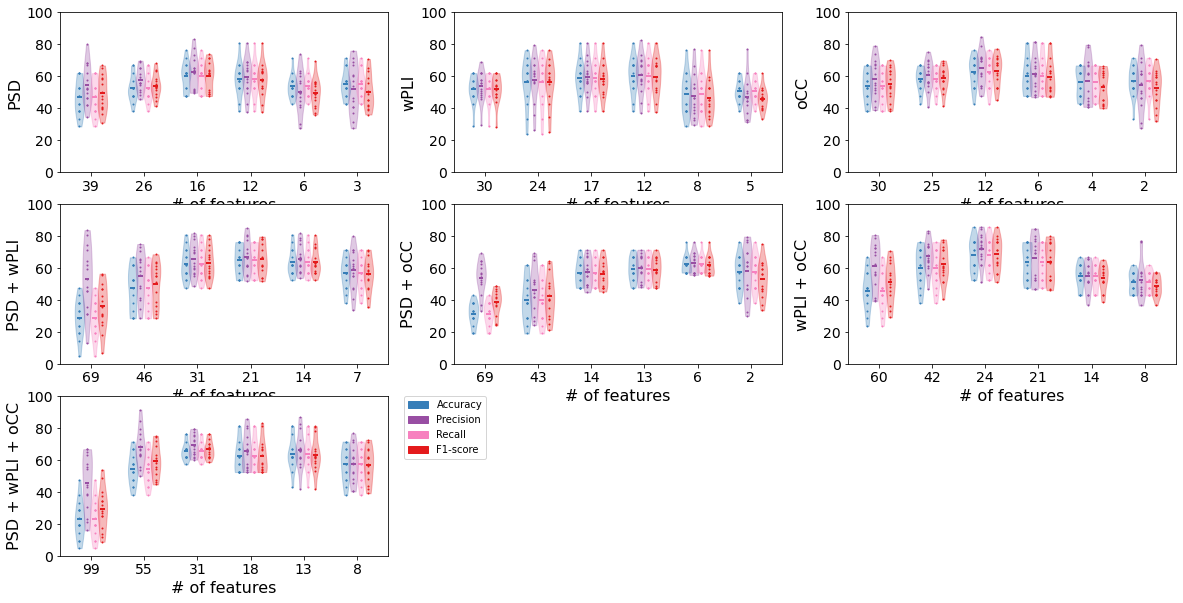

In [13]:
colors = [cmap[0],cmap[5], cmap[3], cmap[7]]
color_line = [cmap[0],cmap[5], cmap[3], cmap[7]]
label = ['Accuracy', 'Precision', 'Recall', 'F1-score']
group_names = ['PSD','wPLI', 'oCC', 'PSD + wPLI', 
               'PSD + oCC', 'wPLI + oCC', 'PSD + wPLI + oCC'] 

plt.figure(figsize=(20, 10))

for i_group in range(n_groups):
    plt.subplot(3, 3, i_group+1)
    tick_labels = np.concatenate(([max_features[i_group]], tick_mat[i_group]))

    for i_score in range(n_scores):
        violin_parts = plt.violinplot(np.multiply(sc_mat[i_group,:,:,i_score].T,100), positions=pos+.2*i_score, vert=True, 
                                          widths=.25,showmeans=True, showextrema=False, showmedians=False)
        for i_fold in range(15):
            plt.scatter((pos+.2*i_score), np.multiply(sc_mat[i_group,:,i_fold,i_score],100), color=color_line[i_score], s=1)
        
        plt.ylim([0, 100])
        plt.ylabel(group_names[i_group], fontsize=16)
        plt.xlabel('# of features', fontsize=16)
        plt.xticks(pos+.3)
        plt.tick_params(labelsize=14)
        ax = plt.gca()
        ax.set_xticklabels(tick_labels.astype('int'))       
        
        for i in range(6):
            violin_parts['bodies'][i].set_alpha(.3)
        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i_score])
            pc.set_edgecolor(color_line[i_score])
            
        vp1 = violin_parts['cmeans']
        vp1.set_edgecolor(color_line[i_score])                    
        vp1.set_linewidth(2)
        
        patch_legend = list()
        for i_score in range(n_scores): 
            patch_legend.append(mpatches.Patch(color=colors[i_score], alpha=1))
            
plt.legend(patch_legend, label, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig(r'' + path_results + 'FigureS3.png', dpi=600, bbox_inches = "tight")
plt.savefig(r'' + path_results + 'FigureS3.svg', dpi=600, bbox_inches = "tight")

In [14]:
colors = ['Blues', 'Purples', 'RdPu', 'Reds']

In [15]:
scores_mean = np.multiply(scores_mat.mean(axis=(2,3)),100)
scores_std = np.multiply(np.std(np.mean(scores_mat,axis = 3),axis=2),100)

In [16]:
tick_labels = np.zeros((7,6))
for i_group in range(n_groups):
    tick_labels[i_group,:] = np.concatenate(([max_features[i_group]], tick_mat[i_group]))

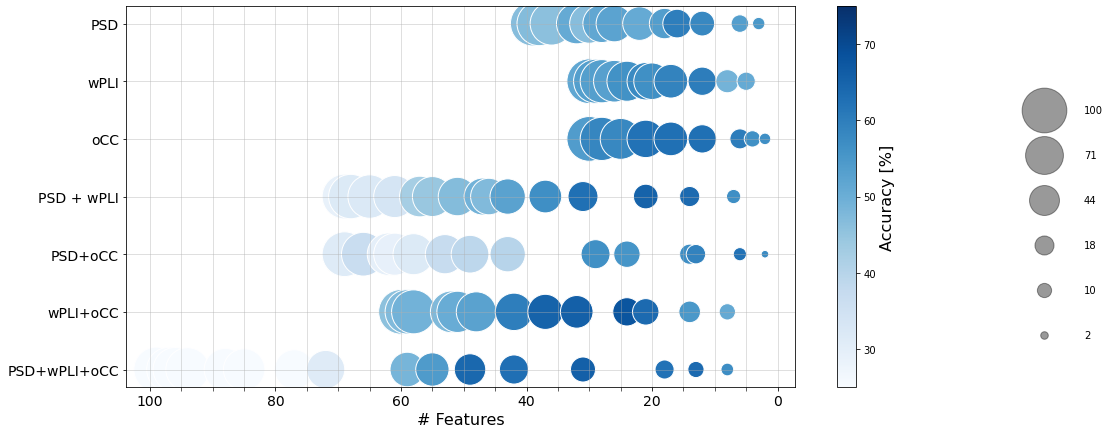

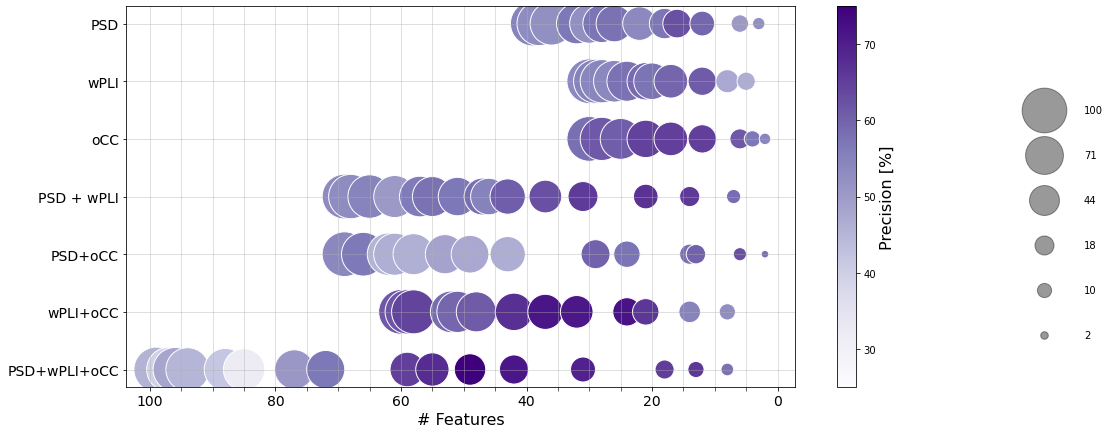

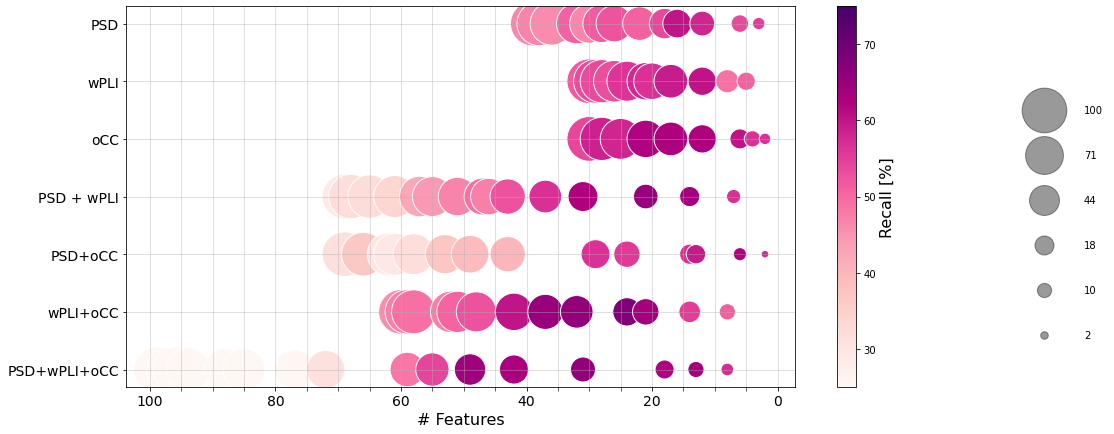

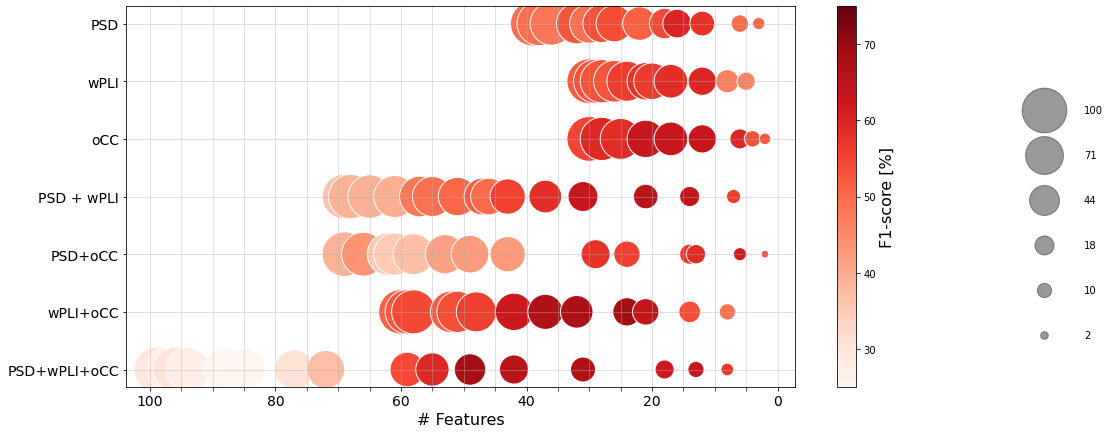

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
color = ['tab:blue', 'tab:purple', 'tab:pink', 'tab:red']
for i_score in range(n_scores):
    fig, ax = plt.subplots(figsize=(15,7))
    bubble_color = scores.mean(axis=(2,3,4))[...,i_score] 
    x = repmat(np.linspace(0,6,7)[np.newaxis].T,1,16)

    scatter_plot = plt.scatter(bubble_size.T, x.T, 
                     s=np.nan_to_num(feature_percentage).T*20, marker='o', 
                     c=bubble_color.T*100, cmap =colors[i_score], 
                     alpha =1, edgecolor='white');
    
   

    cm = plt.colorbar(scatter_plot)
    plt.clim([25,75])
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=4, color='k')
    ax.tick_params(which='major', labelsize=14)
    plt.grid(which='both', alpha=.5)
    
    plt.xlabel('# Features', fontsize=16)

    ax.set_yticklabels(['','PSD', 'wPLI', 'oCC', 'PSD + wPLI', 
                        'PSD+oCC', 'wPLI+oCC', 'PSD+wPLI+oCC'], fontsize=14)
    
    cm.ax.set_ylabel(label_score[i_score]+' [%]', fontsize=16)
    handles, labels = scatter_plot.legend_elements("sizes", alpha=0.4, num=None)

    
    idx = [len(handles)-1, len(handles)-30, len(handles)-45,  
           len(handles)-60, len(handles)-65, 0]
    
    handles_set, labels_set = list(), list()
    for i in idx:
        handles_set.append(handles[i])  
        labels_set.append(int(''.join(list(filter(lambda x: x.isdigit(), labels[i]))))//20)
            
    ax.legend(handles_set, labels_set, bbox_to_anchor=(1.35, .75), loc='upper left', 
              borderaxespad=0., handletextpad=3, frameon=False, labelspacing = 3.5)

    
    namefile = path_results +'MatrixBest_withSize_' + label_score[i_score] 
    fig.savefig(namefile + '.png', dpi=300)
    fig.savefig(namefile + '.svg', dpi=300)
   